In [1]:
from network import HopfieldNetwork
from audio_processing import compute_mel_spectrogram, mel_to_wave, binarize_audio, unbinarize_data, add_noise_to_wav
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
BIT_PRECISION = 8

In [3]:
# Plotting function
def plot(frequencies, train_magnitudes, test_data, prediction, figsize=(10, 6)):
    print("Incoming shape: ", train_magnitudes[0].shape)
    data = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in train_magnitudes]
    test = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in test_data]
    predicted = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in prediction]

    print("Reshaped: ", data[0].shape)

    data = [unbinarize_data(d) for d in data]
    test = [unbinarize_data(d) for d in test]
    predicted = [unbinarize_data(d) for d in predicted]

    print("Unbinarized: ", data[0].shape)

    fig_1, axarr_1 = plt.subplots(len(data), 3, figsize=figsize)
    fig_2, axarr_2 = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr_1[i, 0].set_title('Train data')
            axarr_1[i, 1].set_title("Input data")
            axarr_1[i, 2].set_title('Output data')
            axarr_2[i, 0].set_title('Train data')
            axarr_2[i, 1].set_title("Input data")
            axarr_2[i, 2].set_title('Output data')

        print("Shape to plot: ", data[i].shape)
        axarr_1[i, 0].plot(frequencies, data[i])
        axarr_1[i, 1].plot(frequencies, test[i])
        axarr_1[i, 2].plot(frequencies, predicted[i])
        axarr_2[i, 0].imshow(train_magnitudes[i].reshape(train_magnitudes[i].size // BIT_PRECISION, BIT_PRECISION), aspect='auto', interpolation='none')
        axarr_2[i, 1].imshow(test_data[i].reshape(test_data[i].size // BIT_PRECISION, BIT_PRECISION), aspect='auto', interpolation='none')
        axarr_2[i, 2].imshow(prediction[i].reshape(prediction[i].size // BIT_PRECISION, BIT_PRECISION), aspect='auto', interpolation='none')

    plt.tight_layout()
    plt.savefig("result.png")
    plt.show()

/Users/tim_manley/Documents/College/Thesis/new_code_env/audio_processing.py:83: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = wavfile.read(wave_file)


Norm data:  [0.70710683]
Bin data:  [[ 1 -1  1  1 -1  1 -1 -1]]
Start to train weights...
Weights initialized
(24000, 24000)


100%|██████████| 3/3 [00:10<00:00,  3.63s/it]


Hebb rule step done
Finished training


/Users/tim_manley/Documents/College/Thesis/new_code_env/audio_processing.py:195: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(wav_file)


Start to predict...


100%|██████████| 3/3 [00:25<00:00,  8.37s/it]


Show prediction results...
Incoming shape:  (24000,)
Reshaped:  (3000, 8)
Unbinarized:  (3000,)
Shape to plot:  (3000,)
Shape to plot:  (3000,)
Shape to plot:  (3000,)


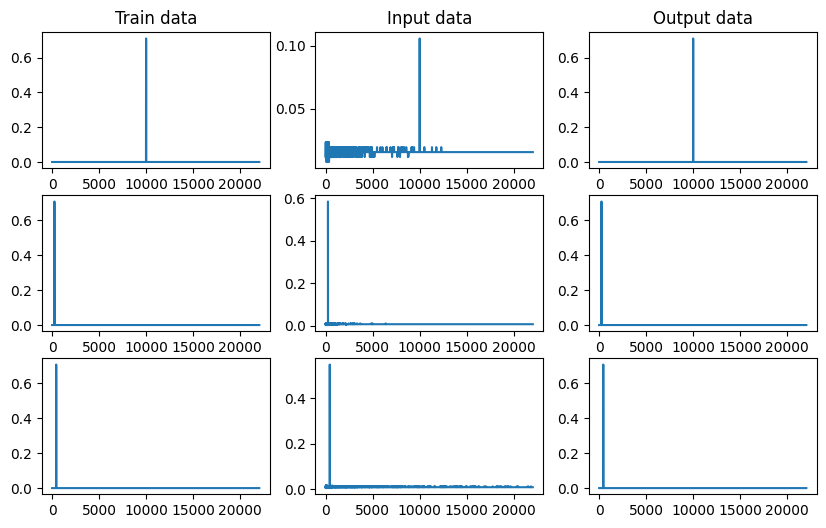

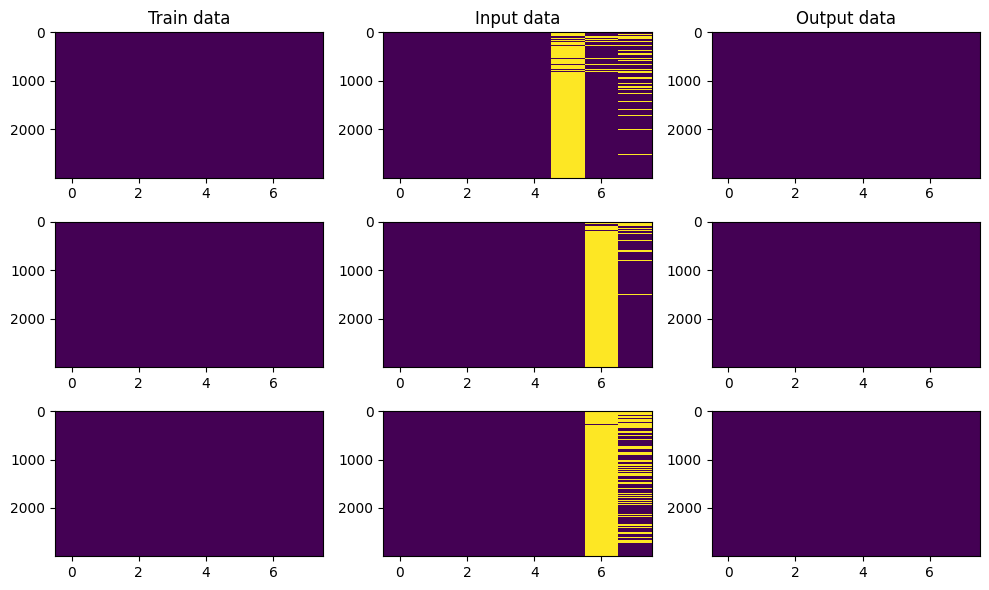

Predicted frequency 1: 9990.771445845947
Predicted frequency 2: 249.71941033547077
Predicted frequency 3: 439.43785879290675


In [14]:
# File names for raw audio
tenk = "./audio/Sine_wave_10k.wav"
two50 = "./audio/Sine_wave_250.wav"
four40 = "./audio/Sine_wave_440.wav"

mel_bins = 3000

# Take the fourier transform of the wav files, reduce the size for memory efficiency TODO: figure out optimal n
mags_10k, frequencies = compute_mel_spectrogram(tenk, mel_bins)
mags_250, _ = compute_mel_spectrogram(two50, mel_bins)
mags_440, _ = compute_mel_spectrogram(four40, mel_bins)

print("Norm data: ", max(normalize(mags_250.reshape(-1, 1), axis=0)))


# Binarize and normalize data
norm_bin_data_10k = binarize_audio(normalize(mags_10k.reshape(-1, 1), axis=0), BIT_PRECISION)
norm_bin_data_250 = binarize_audio(normalize(mags_250.reshape(-1, 1), axis=0), BIT_PRECISION)
norm_bin_data_440 = binarize_audio(normalize(mags_440.reshape(-1, 1), axis=0), BIT_PRECISION)

print("Bin data: ", norm_bin_data_250[np.where(normalize(mags_250.reshape(-1, 1), axis=0) == max(normalize(mags_250.reshape(-1, 1), axis=0)))[0]])

# Initialize the Hopfield network
model = HopfieldNetwork()

# Combine and preprocess training data
raw_data = [norm_bin_data_10k, norm_bin_data_250, norm_bin_data_440]
train_data = [np.reshape(d, (len(d) * BIT_PRECISION)) for d in raw_data]

# Train the weights in the network
model.train_weights(train_data)
print("Finished training")

# Noisy output files
noisy_10k = "./audio/noisy/10k.wav"
noisy_250 = "./audio/noisy/250.wav"
noisy_440 = "./audio/noisy/440.wav"

add_noise_to_wav(tenk, noisy_10k, 10000)
add_noise_to_wav(two50, noisy_250, 10000)
add_noise_to_wav(four40, noisy_440, 10000)

# Get mel magnitudes of noisy files
noisy_mags_10k, _ = compute_mel_spectrogram(noisy_10k, mel_bins)
noisy_mags_250, _ = compute_mel_spectrogram(noisy_250, mel_bins)
noisy_mags_440, _ = compute_mel_spectrogram(noisy_440, mel_bins)

# Binarize and normalize test data
norm_bin_data_10k_noisy = binarize_audio(normalize(noisy_mags_10k.reshape(-1, 1), axis=0), BIT_PRECISION)
norm_bin_data_250_noisy = binarize_audio(normalize(noisy_mags_250.reshape(-1, 1), axis=0), BIT_PRECISION)
norm_bin_data_440_noisy = binarize_audio(normalize(noisy_mags_440.reshape(-1, 1), axis=0), BIT_PRECISION)

noisy_data = [norm_bin_data_10k_noisy, norm_bin_data_250_noisy, norm_bin_data_440_noisy]

test_data = np.array([np.reshape(d, (len(d) * BIT_PRECISION)) for d in noisy_data])

# Make predictions
predicted = model.predict(test_data, num_iter=100, threshold=5, asyn=False)
predicted = np.array(predicted)

# Plot data
print("Show prediction results...")
plot(frequencies, train_data, test_data, predicted)

# Get actual frequency predictions
predicted = [d.reshape(d.size // BIT_PRECISION, BIT_PRECISION) for d in predicted]
predicted = [unbinarize_data(d) for d in predicted]
indices = [np.argmax(d) for d in predicted]
#print(indices)

predicted_freqs = [frequencies[i] for i in indices]
#print(predicted_freqs)

for i, f in enumerate(predicted_freqs):
    print(f"Predicted frequency {i + 1}: {f}")

#model.plot_weights()

/Users/tim_manley/Documents/College/Thesis/new_code_env/audio_processing.py:83: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = wavfile.read(wave_file)


[441.51892879]


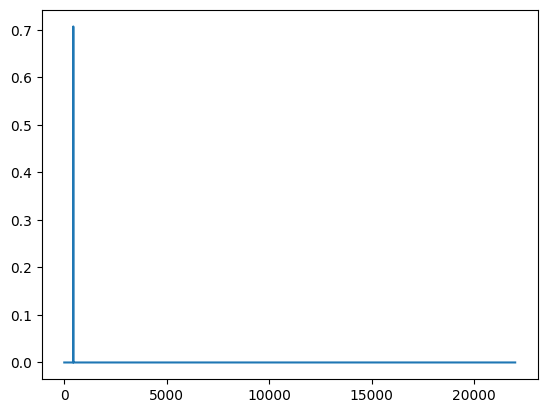

In [5]:
# Compute mel spectrogram of audio
file_path = "./audio/Sine_wave_440.wav"

magnitudes, frequencies = compute_mel_spectrogram(file_path, 1800)

# Normalize the magnitudes
magnitudes = normalize(magnitudes.reshape(-1, 1), axis=0)

print(frequencies[np.where(magnitudes == max(magnitudes))[0]])

plt.plot(frequencies, magnitudes)
plt.show()